## Dependencias necesarias

In [4]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import kagglehub
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import Counter
import random
from tqdm import tqdm
import pandas as pd

## Descarga del dataset

In [6]:
# Download latest version
path = kagglehub.dataset_download("mikhailma/house-rooms-streets-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 295M/295M [00:10<00:00, 29.1MB/s] 

Extracting files...


Path to dataset files: /Users/gerox/.cache/kagglehub/datasets/mikhailma/house-rooms-streets-image-dataset/versions/1


## Analizar la estructura

In [7]:
for root, dirs, files in os.walk(path):
    level = root.replace(path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    if level < 2:  # Solo mostrar 2 niveles
        for d in dirs:
            subdir_path = os.path.join(root, d)
            n_files = len([f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))])
            print(f'{indent}  {d}/ ({n_files} archivos)')

1/
  kaggle_room_street_data/ (0 archivos)
  kaggle_room_street_data/
    house_data/ (5249 archivos)
    street_data/ (19658 archivos)
    house_data/
    street_data/


## Análisis de exploración

In [9]:
street_path = "/Users/gerox/.cache/kagglehub/datasets/mikhailma/house-rooms-streets-image-dataset/versions/1/kaggle_room_street_data/street_data"
print(f"Existe: {os.path.isdir(street_path)}")

CATEGORIES = ['apartment', 'church', 'garage', 'house', 'industrial', 'office_building', 'retail', 'roof', 'officebuilding']

img_paths = []
labels = []
skipped = []

for file in tqdm(os.listdir(street_path), desc='street_data'):
    if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.webp')):
        found = None
        for cat in CATEGORIES:
            if cat in file.lower():
                found = cat
                break
        if found:
            img_paths.append(os.path.join(street_path, file))
            labels.append(found)
        else:
            skipped.append(file)

df = pd.DataFrame({
    'img_path': img_paths,
    'label': labels
})

print(f"Total imágenes asignadas: {len(df)}")
print(f"Imágenes sin categoría: {len(skipped)}")
if skipped:
    print(f"Ejemplos skipped: {skipped[:5]}")

print(f"\nCategorías ({df['label'].nunique()}):")
print(df['label'].value_counts())

Existe: True


street_data: 100%|██████████| 19658/19658 [00:00<00:00, 1198424.83it/s]

Total imágenes asignadas: 19354
Imágenes sin categoría: 304
Ejemplos skipped: ['portland_BdIdx_14040_BdType_commercial.jpg', 'sandiego_BdIdx_22239_BdType_commercial.jpg', 'sandiego_BdIdx_17375_BdType_commercial.jpg', 'cleveland_BdIdx_20047_BdType_commercial.jpg', 'cleveland_BdIdx_2446_BdType_commercial.jpg']

Categorías (8):
label
apartment         2493
retail            2465
house             2450
industrial        2446
church            2446
garage            2431
roof              2423
officebuilding    2200
Name: count, dtype: int64


## Visualización - Distribución

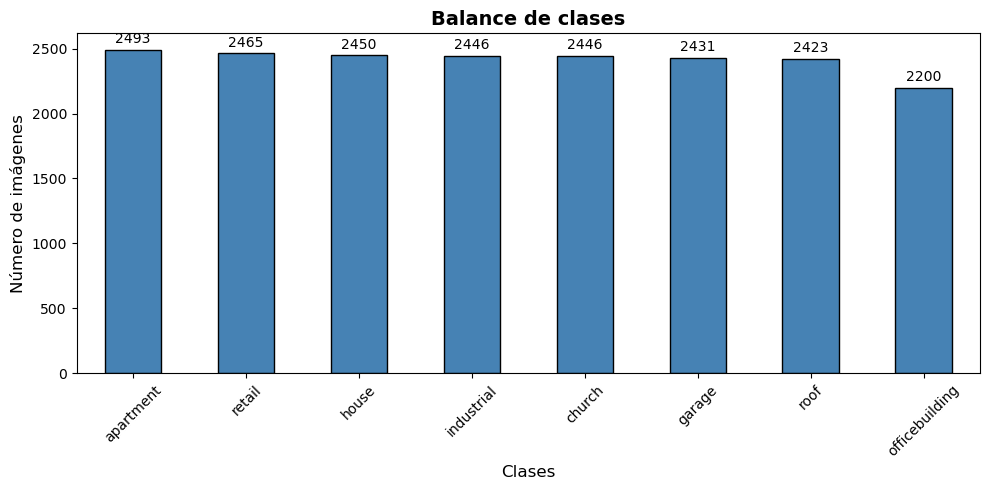

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
counts = df['label'].value_counts()
counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_title('Balance de clases', fontsize=14, fontweight='bold')
ax.set_xlabel('Clases', fontsize=12)
ax.set_ylabel('Número de imágenes', fontsize=12)
ax.tick_params(axis='x', rotation=45)
for i, v in enumerate(counts):
    ax.text(i, v + 50, str(v), ha='center', fontsize=10)
plt.tight_layout()
plt.savefig('balance_clases.png', dpi=150, bbox_inches='tight')
plt.show()

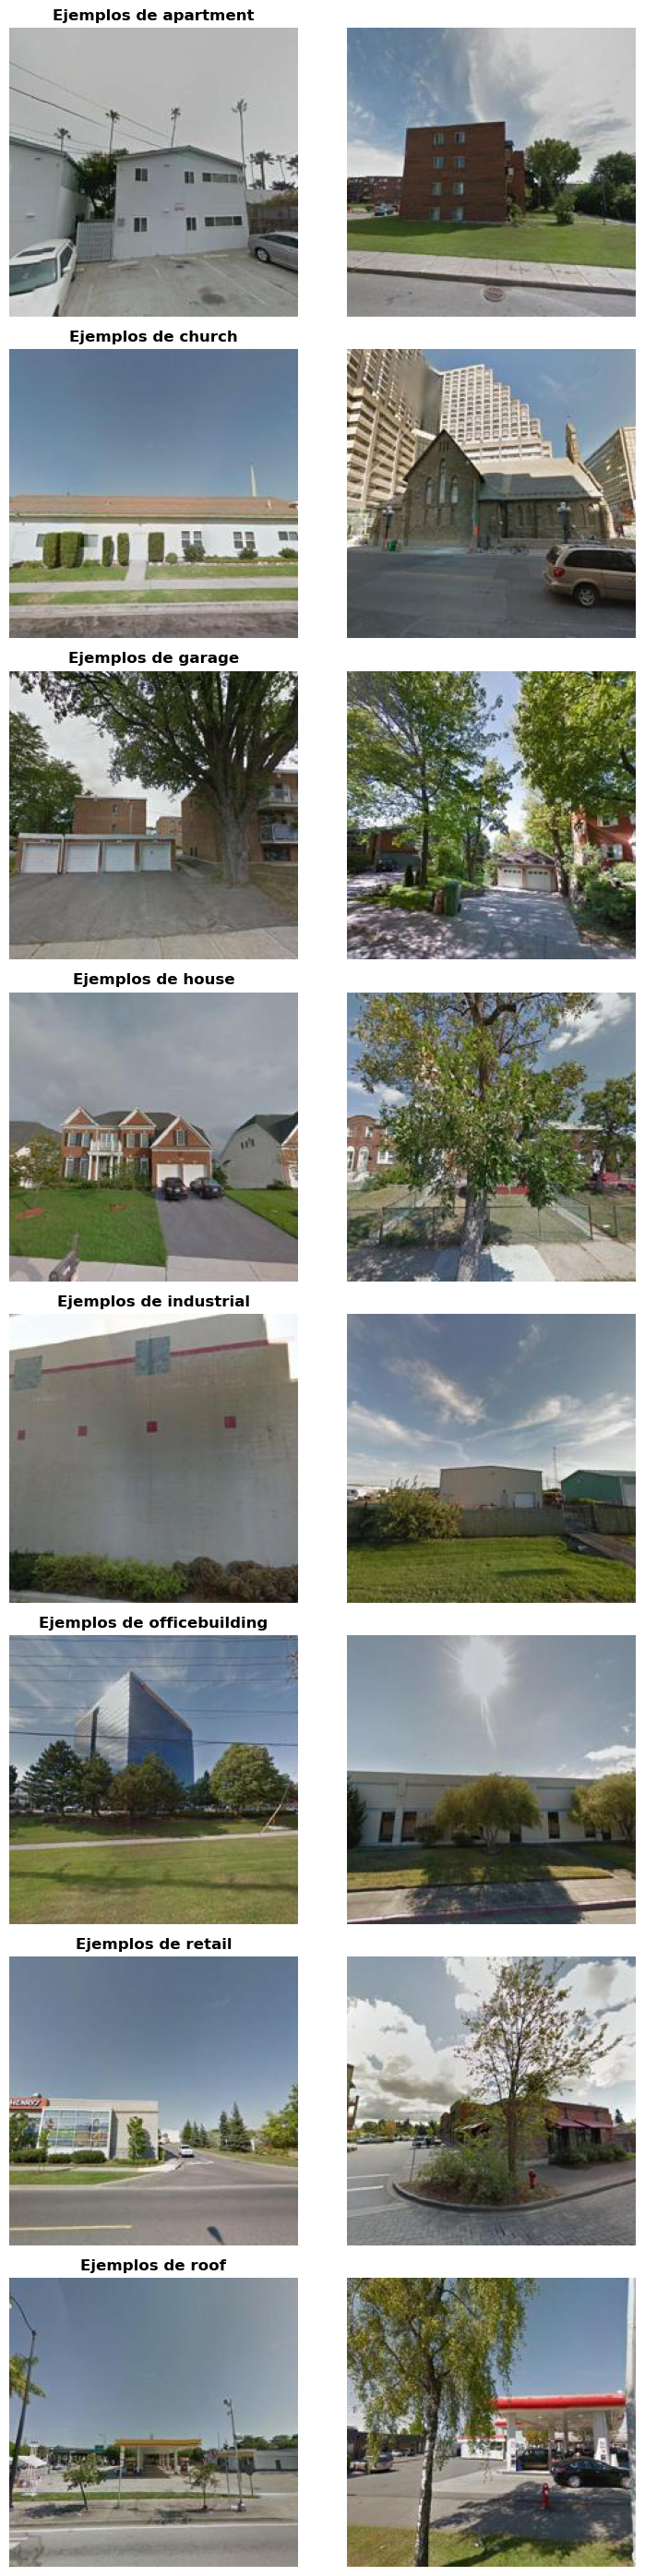

In [11]:
categories = sorted(df['label'].unique())
n_samples = 2

fig, axes = plt.subplots(len(categories), n_samples, figsize=(8, 3.5 * len(categories)))

for i, cat in enumerate(categories):
    cat_paths = df[df['label'] == cat]['img_path'].tolist()
    samples = random.sample(cat_paths, min(n_samples, len(cat_paths)))

    for j, img_path in enumerate(samples):
        img = Image.open(img_path)
        axes[i][j].imshow(img)
        axes[i][j].axis('off')
        if j == 0:
            axes[i][j].set_title(f'Ejemplos de {cat}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('ejemplos_por_clase.png', dpi=150, bbox_inches='tight')
plt.show()

### Propiedades de las imágenes

In [12]:
widths, heights, sizes, modes = [], [], [], []
for path in tqdm(df['img_path']):
    img = Image.open(path)
    widths.append(img.size[0])
    heights.append(img.size[1])
    sizes.append(os.path.getsize(path) / 1024)
    modes.append(img.mode)

df['width'] = widths
df['height'] = heights
df['size_kb'] = sizes
df['mode'] = modes

print(f"Resoluciones únicas: {df[['width','height']].drop_duplicates().shape[0]}")
print(f"Rango resolución: {df['width'].min()}x{df['height'].min()} a {df['width'].max()}x{df['height'].max()}")
print(f"Tamaño promedio: {df['size_kb'].mean():.1f} KB")
print(f"Modos de color: {df['mode'].value_counts().to_dict()}")

100%|██████████| 19354/19354 [00:02<00:00, 8077.93it/s]

Resoluciones únicas: 1
Rango resolución: 224x224 a 224x224
Tamaño promedio: 9.2 KB
Modos de color: {'RGB': 19354}


### Distribución de resoluciones

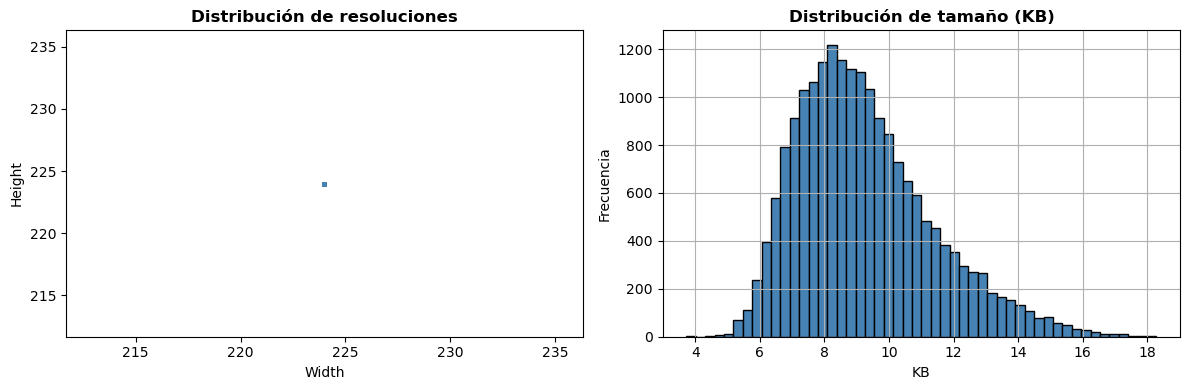

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(df['width'], df['height'], alpha=0.3, s=5, c='steelblue')
axes[0].set_title('Distribución de resoluciones', fontweight='bold')
axes[0].set_xlabel('Width')
axes[0].set_ylabel('Height')

df['size_kb'].hist(ax=axes[1], bins=50, color='steelblue', edgecolor='black')
axes[1].set_title('Distribución de tamaño (KB)', fontweight='bold')
axes[1].set_xlabel('KB')
axes[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.savefig('resoluciones_y_tamanos.png', dpi=150, bbox_inches='tight')
plt.show()

### Distribución colores promedio

100%|██████████| 19354/19354 [00:09<00:00, 2077.41it/s]


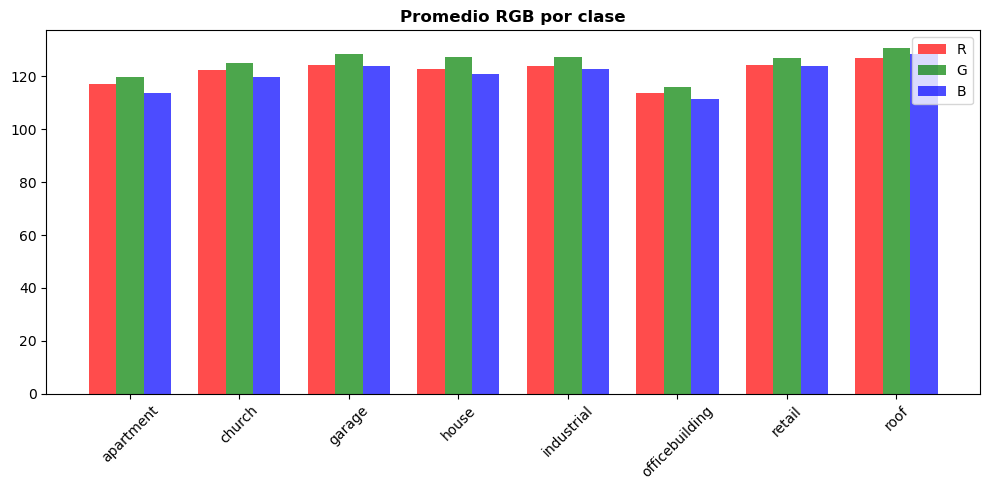

In [14]:
avg_colors = {cat: [] for cat in categories}

for _, row in tqdm(df.iterrows(), total=len(df)):
    img = np.array(Image.open(row['img_path']).convert('RGB').resize((64, 64)))
    avg_colors[row['label']].append(img.mean(axis=(0,1)))

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(categories))
for idx, (channel, color) in enumerate(zip(['R', 'G', 'B'], ['red', 'green', 'blue'])):
    means = [np.mean([c[idx] for c in avg_colors[cat]]) for cat in categories]
    ax.bar(x + idx*0.25, means, 0.25, label=channel, color=color, alpha=0.7)

ax.set_xticks(x + 0.25)
ax.set_xticklabels(categories, rotation=45)
ax.set_title('Promedio RGB por clase', fontweight='bold')
ax.legend()
plt.tight_layout()
plt.savefig('rgb_por_clase.png', dpi=150, bbox_inches='tight')
plt.show()